# Solution: Neonatal vaccination to reduce prevalence of an endemic disease in livestock

## Setting up the model: 

The SIR structure needs to be extended to incorporate vaccinated births (going into the R compartment), unvaccinated births (going into the S compartment), deaths, and waning immunity. As we are modelling an endemic infection, the initial conditions for the population don't matter as long as they add up to 300000 according to the instructions (this is because all initial conditions will end up at the same endemic equilibrium, given enough time). For the baseline scenario, we are assuming no vaccine coverage (*p_vacc* = 0) and no waning of immunity ($\sigma$ = 0). 

<img src="w4_nb4_model_diagram.png">

## Modelling the baseline (no vaccination) assuming permanent immunity:

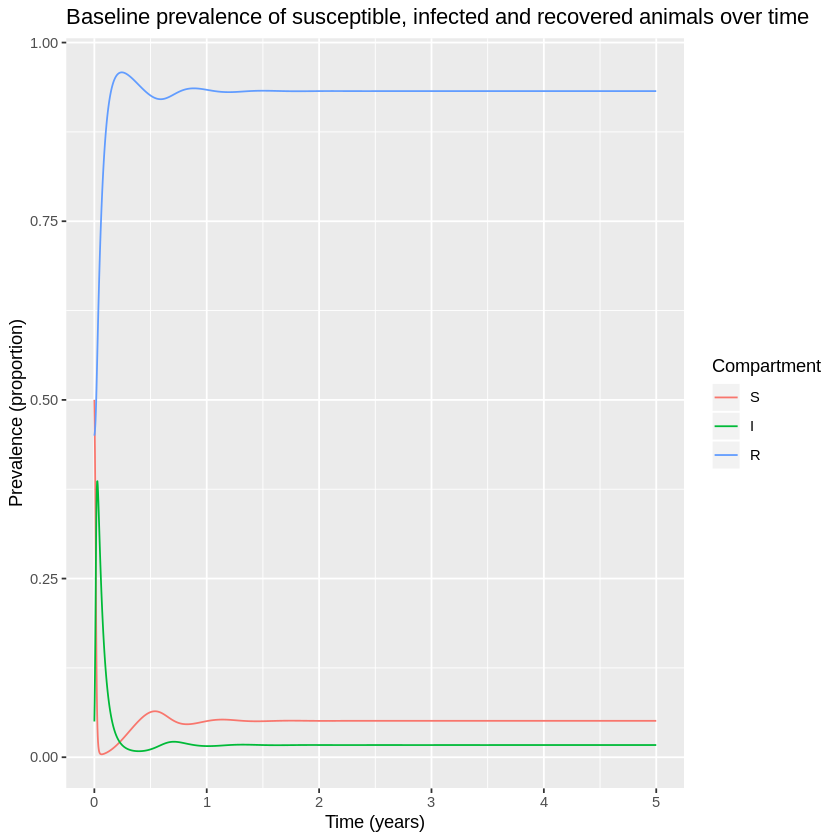

In [2]:
# LOAD THE PACKAGES:
library(deSolve)
library(reshape2)
library(ggplot2)

# MODEL INPUTS:

# Vector storing the initial number in each compartment (at timestep 0)

N <- 300000

initial_state_values <- c(S = 0.5*N,  
                          I = 0.05*N,      
                          R = 0.45*N)     
# the exact proportions here don't matter, we have chosen an infection prevalence of 5% to start with in line with the
# information that the disease is thought to be relatively rare in this population. 
# As described above, any initial conditions will converge on the same endemic equilibrium, given enough time.

# Vector storing the parameters describing the transition rates in units of years^-1
parameters <- c(beta = 365/1,            # the infection rate
                gamma = 365/20,          # the rate of recovery
                mu = 1/3,                # the background mortality rate
                b = 1/3,                 # the birth rate
                p_vacc = 0,              # the neonatal vaccine coverage
                sigma = 0)               # the rate at which immunity wanes                   

# TIMESTEPS:

# Vector storing the sequence of timesteps to solve the model at
times <- seq(from = 0, to = 5, by = 1/365)   # from 0 to 5 years in daily intervals
# We are simulating over a period of 10 years to allow the model to come to equilibrium. 
# You might need a different timespan depending on the initial conditions you chose.

# SIR MODEL FUNCTION: 

# The model function takes as input arguments (in the following order): time, state and parameters
sir_model <- function(time, state, parameters) {  

    with(as.list(c(state, parameters)), {  # tell R to unpack variable names from the state and parameters inputs   
        
    # Calculating the total population size N (the sum of the number of people in each compartment)
      N <- S+I+R
      
    # Defining lambda as a function of beta and I:
      lambda <- beta * I/N
        
    # The differential equations
      dS <- -lambda*S - mu*S + (1-p_vacc)*b*N + sigma*R           
      dI <- lambda*S - gamma*I  - mu*I           
      dR <- gamma*I - mu*R  + p_vacc*b*N - sigma*R   
    
    # Because this is a neonatal vaccine (given straight after birth), we model this simply as a proportion p_vacc
    # of births entering the R compartment (Recovered/Immune),
    # with the remaining births (1-p_vacc) entering the susceptible compartment.
      
    # Output the number in the S, I and R compartments at each timestep 
    # (in the same order as the input state variables)
    return(list(c(dS, dI, dR))) 
    })
  
}

# MODEL OUTPUT (solving the differential equations):

# Solving the differential equations using the ode integration algorithm
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters))

# PLOT

output_long <- melt(as.data.frame(output), id = "time")                  # turn output dataset into long format

# Calculating the proportion in each compartment as a column in the long-format output
output_long$proportion <- output_long$value/sum(initial_state_values)

# Plot the proportion in the S, I and R compartments over time
ggplot(data = output_long,                                               # specify object containing data to plot
       aes(x = time, y = proportion, colour = variable, group = variable)) +  # assign columns to axes and groups
  geom_line() +                                                          # represent data as lines
  xlab("Time (years)")+                                                  # add label for x axis
  ylab("Prevalence (proportion)") +                                      # add label for y axis
  labs(colour = "Compartment",                                           # add legend title  
       title = "Baseline prevalence of susceptible, infected and recovered animals over time")

### What is the endemic prevalence of the disease currently (the baseline prevalence), assuming permanent immunity?

In [4]:
# The prevalence seems to have stabilised by 2 years:
# calculating the prevalence in year 2
output_long$proportion[round(output_long$time,0) == 2 & output_long$variable == "I"][1]

# Note that here we are selecting the proportion infected at timestep 2, 
# but since the timesteps are not exact numbers, we are selecting the timesteps that, when rounded to 0 decimals,
# is and display only the first one of those

[1] 0.01703558

In [ ]:
output_lo

The baseline prevalence is 1.7%.

From the output, we can also get the number in each compartment at endemic equilibrium and use these as the initial conditions in the vaccine model:

In [3]:
output[output$time == 2,]  # print state values at equilibrium

,time,S,I,R
731,2,15253.83,5125.043,279621.1


## Reducing the prevalence to around 0.85% using the neonatal vaccine, assuming permanent immunity:

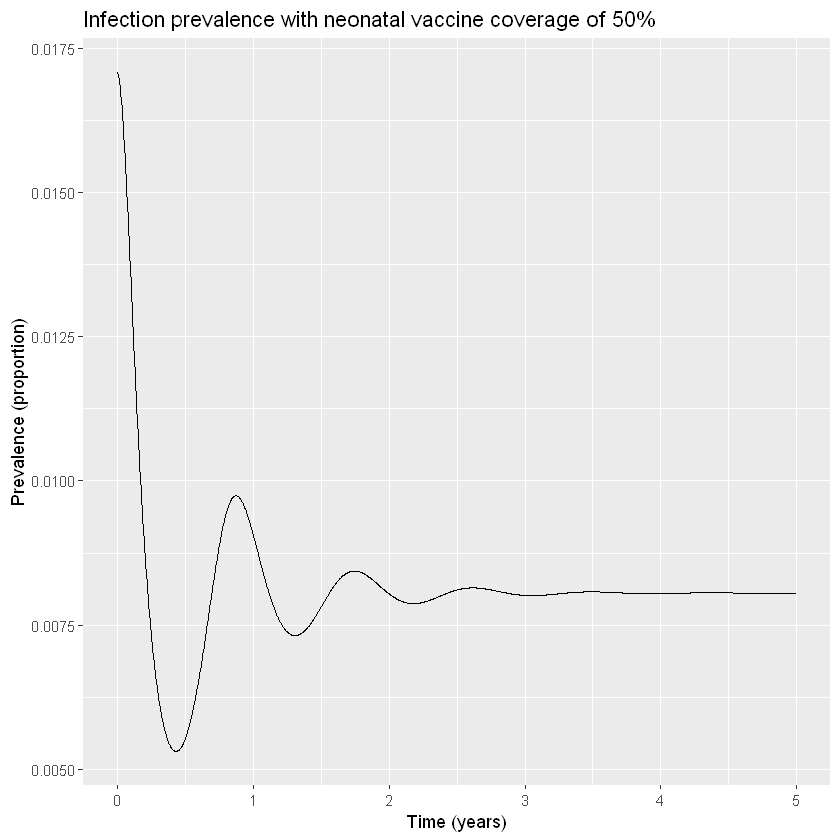

In [4]:
# Before introducing a vaccine, change initial state values to baseline endemic equilibrium
initial_state_values <- c(S = 15254,  
                          I = 5125,      
                          R = 279621)    

parameters["p_vacc"] <- 0.5   # try different coverage values to find an endemic prevalence of half the baseline prevalence

# MODEL OUTPUT (solving the differential equations):

# Solving the differential equations using the ode integration algorithm
output <- as.data.frame(ode(y = initial_state_values, 
                             times = times, 
                             func = sir_model,
                             parms = parameters))

output_long <- melt(as.data.frame(output), id = "time")                  # turn output dataset into long format

# Calculating the proportion in each compartment as a column in the long-format output
output_long$proportion <- output_long$value/sum(initial_state_values)

# PLOT

# Plot the proportion in the I compartment over time: divide the number in I over time by the total population size
ggplot(data = output,                                                    # specify object containing data to plot
       aes(x = time, y = output$I/N)) +                                  # assign columns to axes and groups
  geom_line() +                                                          # represent data as lines
  xlab("Time (years)")+                                                  # add label for x axis
  ylab("Prevalence (proportion)") +                                      # add label for y axis
  labs(colour = "Compartment",                                           # add legend title  
       title = "Infection prevalence with neonatal vaccine coverage of 50%")

In [5]:
# Calculating the prevalence in year 5 (introduction of the vaccine at first perturbs the initial equilibrium, but
# we are interested in the new endemic equilibrium achieved with vaccination)
output_long$proportion[round(output_long$time,0) == 5 & output_long$variable == "I"][1]

[1] 0.008058337

### What proportion of newborn animals would you need to vaccinate to reduce the prevalence by half, assuming life-long immunity?

If immunity  induced by infection and vaccination is lifelong, we only need to vaccinate around 50% of all newborns to achieve a reduction of the endemic prevalence to less than 0.85%.

## Increasing the vaccine coverage to achieve elimination:

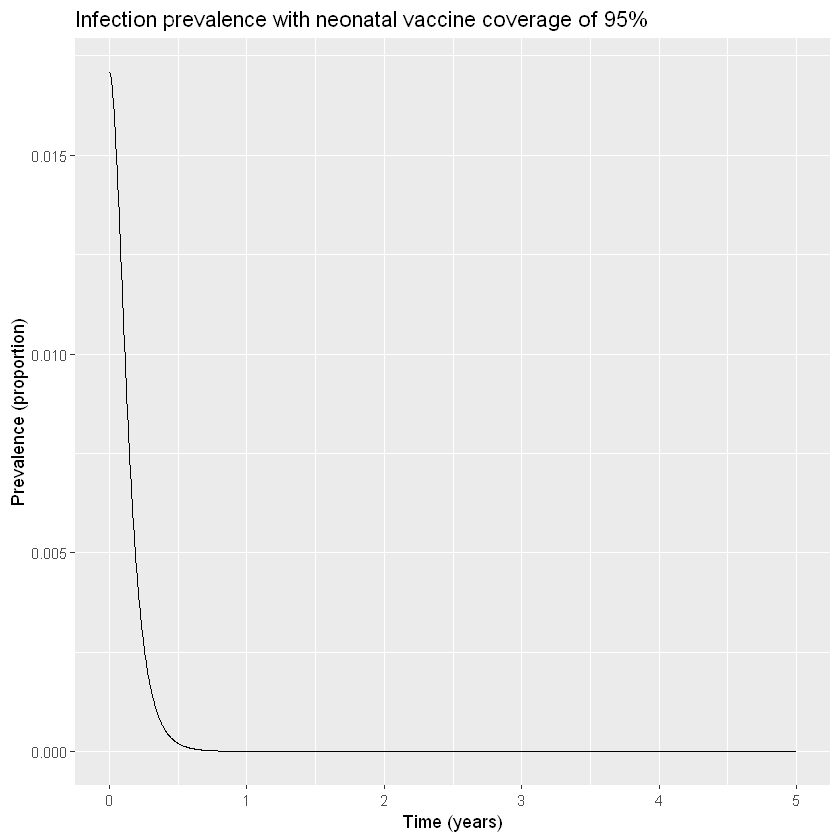

In [6]:
parameters["p_vacc"] <- 0.95   # try different coverage values to see if the disease persists

# MODEL OUTPUT (solving the differential equations):

# Solving the differential equations using the ode integration algorithm
output <- as.data.frame(ode(y = initial_state_values, 
                             times = times, 
                             func = sir_model,
                             parms = parameters))

output_long <- melt(as.data.frame(output), id = "time")                  # turn output dataset into long format

# Calculating the proportion in each compartment as a column in the long-format output
output_long$proportion <- output_long$value/sum(initial_state_values)

# PLOT

# Plot the proportion in the I compartment over time: divide number in I over time by the total population size
ggplot(data = output,                                                    # specify object containing data to plot
       aes(x = time, y = output$I/N)) +                                  # assign columns to axes and groups
  geom_line() +                                                          # represent data as lines
  xlab("Time (years)")+                                                  # add label for x axis
  ylab("Prevalence (proportion)") +                                      # add label for y axis
  labs(colour = "Compartment",                                           # add legend title  
       title = "Infection prevalence with neonatal vaccine coverage of 95%")

In [7]:
# Double-check how many animals remain infected at the 5 year timestep
output[round(output$time,0) == 5,"I"][1]

[1] 4.904184e-09

### Would it be possible to eliminate the disease from the population using neonatal vaccination under the assumption of lifelong immunity?

The model suggests that yes, with a vaccine coverage of 95% or higher, it appears that the disease dies out. We could define elimination as the reduction of prevalence to a certain threshold value. Here, we have simply checked that infection dies out eventually, with a prevalence that tends towards zero over time and less than 1 animal remaining infected at the end of the simulation.

## Modelling the baseline prevalence and impact of vaccination assuming immunity with an average duration of 1 year:

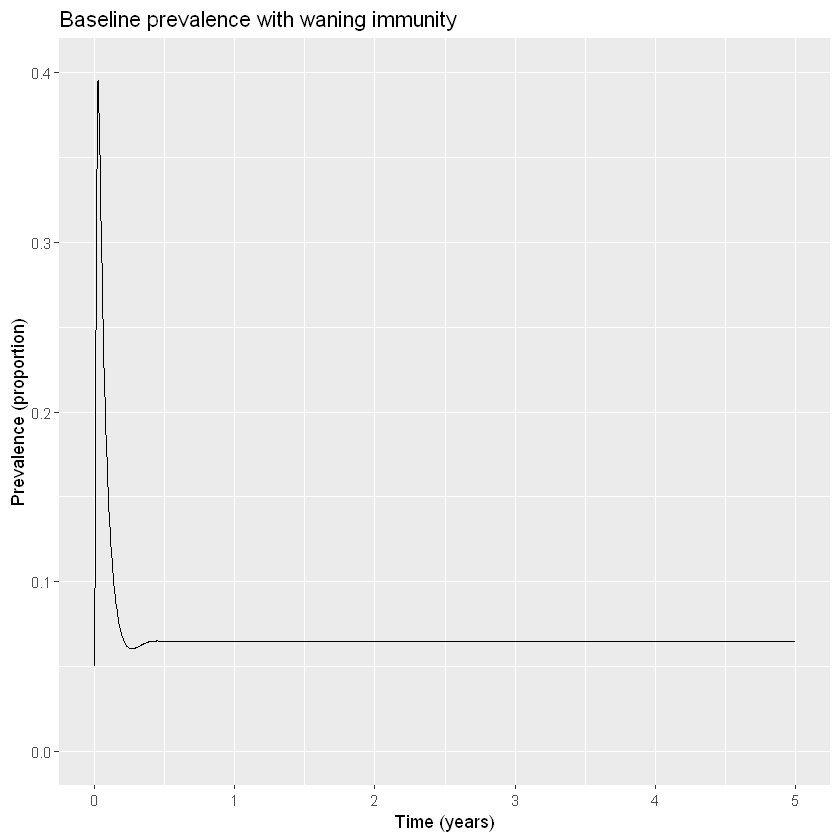

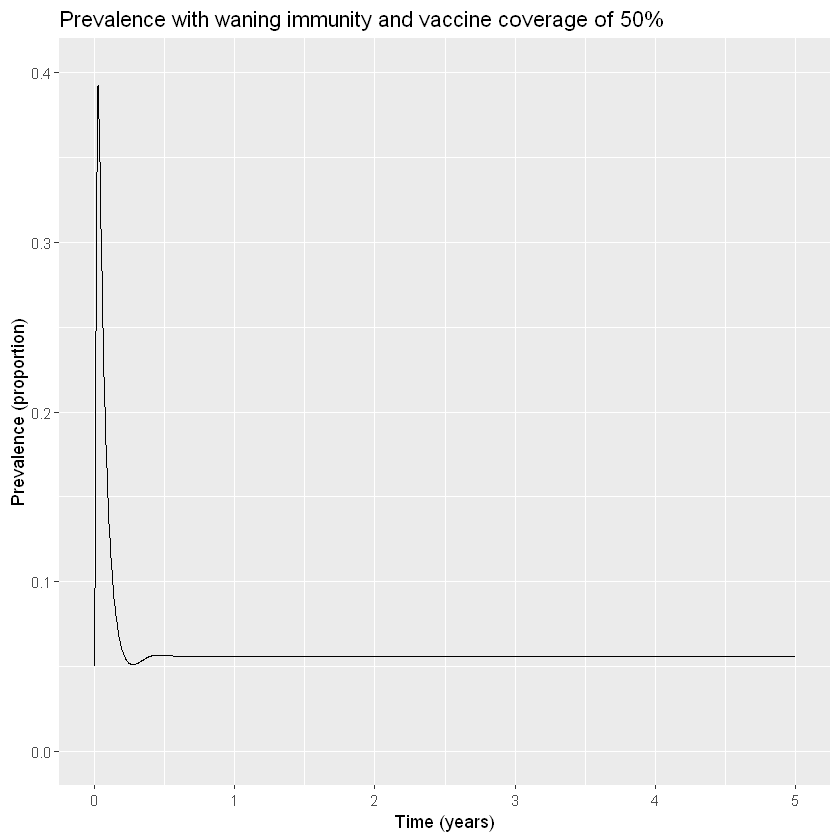

In [8]:
# BASELINE SCENARIO WITH WANING IMMUNITY

initial_state_values <- c(S = 0.5*N,  
                          I = 0.05*N,      
                          R = 0.45*N)

parameters["p_vacc"] <- 0
parameters["sigma"] <- 1

waning_baseline <- as.data.frame(ode(y = initial_state_values, 
                                     times = times, 
                                     func = sir_model,
                                     parms = parameters))

waning_baseline_long <- melt(as.data.frame(waning_baseline), id = "time")   

# Calculating the proportion in each compartment
waning_baseline_long$proportion <- waning_baseline_long$value/sum(initial_state_values)

# VACCINE SCENARIO WITH WANING IMMUNITY

parameters["p_vacc"] <- 0.5
parameters["sigma"] <- 1

waning_vacc <- as.data.frame(ode(y = initial_state_values, 
                                     times = times, 
                                     func = sir_model,
                                     parms = parameters))

waning_vacc_long <- melt(as.data.frame(waning_vacc), id = "time")   

# Calculating the proportion in each compartment
waning_vacc_long$proportion <- waning_vacc_long$value/sum(initial_state_values)

# PLOTTING THE 2 SCENARIOS

# Baseline
ggplot(data = waning_baseline,                                           # specify object containing data to plot
       aes(x = time, y = I/N)) +                                         # assign columns to axes and groups
  geom_line() +                                                          # represent data as lines
  xlab("Time (years)")+                                                  # add label for x axis
  ylab("Prevalence (proportion)") +                                      # add label for y axis
  labs(colour = "Compartment",                                           # add legend title  
       title = "Baseline prevalence with waning immunity") +
  ylim(c(0,0.4))                                                         # define y axis range to be plotted (0-0.4)

# With vaccine
ggplot(data = waning_vacc,                                               # specify object containing data to plot
       aes(x = time, y = I/N)) +                                         # assign columns to axes and groups
  geom_line() +                                                          # represent data as lines
  xlab("Time (years)")+                                                  # add label for x axis
  ylab("Prevalence (proportion)") +                                      # add label for y axis
  labs(colour = "Compartment",                                           # add legend title  
       title = "Prevalence with waning immunity and vaccine coverage of 50%") +
  ylim(c(0,0.4))                                                         # define y axis range to be plotted (0-0.4)

In [9]:
# Calculating the baseline prevalence with waning immunity
waning_baseline_prev <- waning_baseline_long$proportion[round(waning_baseline_long$time,0) == 2 & 
                                                        waning_baseline_long$variable == "I"][1]

# Calculating the endemic prevalence with waning immunity and neonatal vaccination coverage of 50%
waning_vacc_prev <- waning_vacc_long$proportion[round(waning_vacc_long$time,0) == 2 & 
                                                waning_vacc_long$variable == "I"][1]

# Calculating the reduction in prevalence achieved with 50% neonatal vaccine coverage:
1-waning_vacc_prev/waning_baseline_prev

[1] 0.1317056

### If the average duration of immunity is only 1 year, how would this impact the proportional reduction in the prevalence with the vaccine coverage you obtained above compared to the baseline? 

If immunity is not permanent but wanes on average after a duration of 1 year in the recovered compartment, a neonatal vaccine coverage of 50% now only leads to a 13% reduction in disease prevalence compared to baseline, rather than 50%. 

## Modelling the impact of vaccination with 100% coverage assuming immunity with an average duration of 1 year:

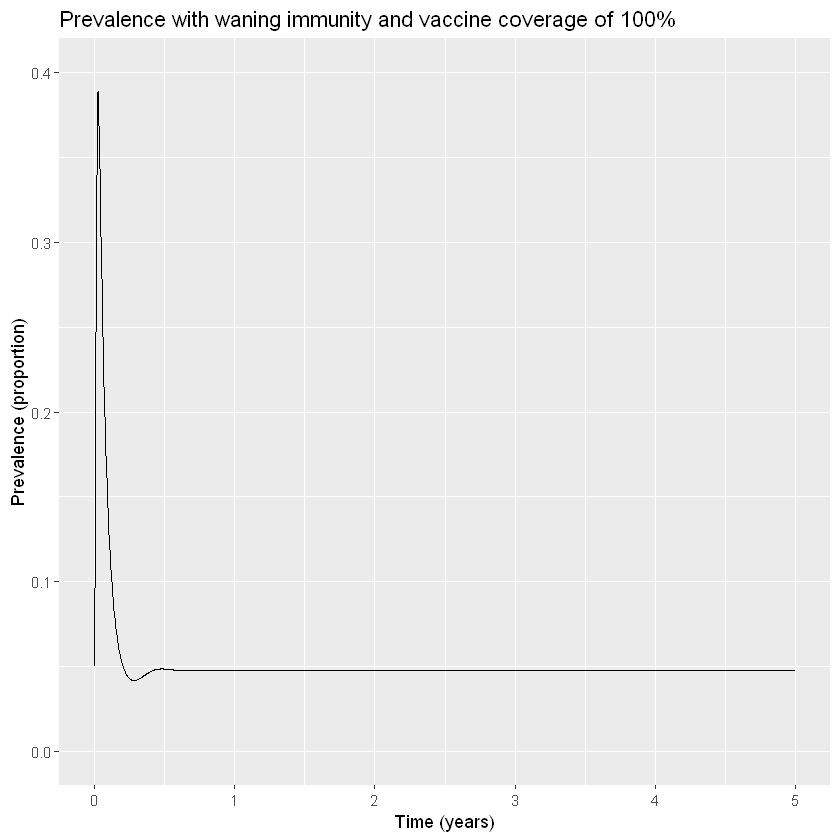

In [10]:
# VACCINE SCENARIO WITH WANING IMMUNITY: INCREASING COVERAGE TO 100%

parameters["p_vacc"] <- 1
parameters["sigma"] <- 1

waning_vacc <- as.data.frame(ode(y = initial_state_values, 
                                     times = times, 
                                     func = sir_model,
                                     parms = parameters))

# With vaccine
ggplot(data = waning_vacc,                                      # specify object containing data to plot
       aes(x = time, y = I/N)) +  # assign columns to axes and groups
  geom_line() +                                                          # represent data as lines
  xlab("Time (years)")+                                                  # add label for x axis
  ylab("Prevalence (proportion)") +                                      # add label for y axis
  labs(colour = "Compartment",                                           # add legend title  
       title = "Prevalence with waning immunity and vaccine coverage of 100%") +
ylim(c(0,0.4))

### Would it be possible to eliminate the disease from the population using neonatal vaccination under these assumptions? What minimum vaccine coverage would this require?

If immunity only persists for 1 year on average, the model prediction suggests elimination of the disease using neonatal vaccination alone would not be possible. Even with 100% coverage, the prevalence remains at around 5%.

## Modelling the baseline prevalence and impact of vaccination with 100% coverage assuming immunity with an average duration of 2.5 years:

In [11]:
# BASELINE SCENARIO WITH WANING IMMUNITY

parameters["p_vacc"] <- 0
parameters["sigma"] <- 1/2.5

waning_baseline <- as.data.frame(ode(y = initial_state_values, 
                                     times = times, 
                                     func = sir_model,
                                     parms = parameters))

waning_baseline_long <- melt(as.data.frame(waning_baseline), id = "time")   

# Calculating the proportion in each compartment
waning_baseline_long$proportion <- waning_baseline_long$value/sum(initial_state_values)

# VACCINE SCENARIO WITH WANING IMMUNITY

parameters["p_vacc"] <- 1
parameters["sigma"] <- 1/2.5

waning_vacc <- as.data.frame(ode(y = initial_state_values, 
                                     times = times, 
                                     func = sir_model,
                                     parms = parameters))

waning_vacc_long <- melt(as.data.frame(waning_vacc), id = "time")   

# Calculating the proportion in each compartment
waning_vacc_long$proportion <- waning_vacc_long$value/sum(initial_state_values)

# Calculating the baseline prevalence with slower waning immunity
print("Baseline prevalence:")
waning_baseline_long$proportion[round(waning_baseline_long$time,0) == 2 & waning_baseline_long$variable == "I"][1]
# Calculating the endemic prevalence with slower waning immunity and neonatal vaccination coverage of 100%
print("Prevalence with neonatal vaccine coverage of 100%:")
waning_vacc_long$proportion[round(waning_vacc_long$time,0) == 2 & waning_vacc_long$variable == "I"][1]

[1] "Baseline prevalence:"


[1] 0.03666481

[1] "Prevalence with neonatal vaccine coverage of 100%:"


[1] 0.0189942

### If an adjuvant (a vaccine promoter) was given along with the vaccine, that would extend the duration of immunity to 2.5 years on average, what vaccine coverage would be needed to reduce the baseline prevalence by half? Would it be possible to eliminate the disease from the population under these assumptions using neonatal vaccination?

If the average duration of immunity was increased to an average of 2.5 years by giving an adjuvant, the baseline prevalence could be reduced to about half (from 3.7% to 1.9%) by achieving a neonatal vaccine coverage of 100%. This means that neonatal vaccination alone is not enough to eliminate the disease from the population as it remains endemic even if every newborn animal is vaccinated. 

### Based on your results, what overall recommendation would you give to the Minister?

The modelling analysis suggests that neonatal vaccination can lead to substantial reductions in endemic prevalence of the disease if recovery and vaccination provide long-term immunity, even if not lifelong. However, the vaccine coverage required to achieve a halving of the endemic prevalence and the impact of the neonatal vaccination in general are strongly dependent on the assumptions we make about waning of immunity. If immunity is only short-term, even perfect coverage of the neonatal vaccine would have limited impact, and elimination of the disease seems only possible if immunity does not wane.

Therefore, the modelling results are inconclusive regarding the current prevalence and the impact of neonatal vaccination until further knowledge on the waning or persistence of immunity becomes available. The Minister could consider investing into further research on this. If neonatal vaccination is implemented and immunity is found to wane quickly, addition of an adjuvant could improve the impact of vaccination.

### Also provide some information to help the Minister interpret these results. Write down the assumptions in your modelling approach that you think might affect your results. Are there any adaptations you could make to the model structure that would make it more realistic or that would allow you to answer more detailed questions?

The results have shown that the conclusions strongly depend on the assumptions we made about the rate of waning of immunity. Other assumptions that might impact our results are for example:
- we assume vaccination is applied to a proportion *p_vacc* of births at every timestep, i.e. to all newborns all the time
- we assume vaccine-induced immunity and immunity provided by recovery from natural infection confer the same protection and wane at the same time
- we assume transmission is independent of age-mixing, but the vaccine is only given to newborns, so its effect might change depending on the rate at which different age groups transmit and acquire infection

In future weeks, we will see how to stratify the model into different age groups, to allow for mixing between these groups. We could also investigate the effect these assumptions have on the result by having separate immune compartments and waning rates for those recovered and those vaccinated. We could also give more information on the timescales of this intervention by modelling the baseline case and vaccine introduction chronologically. In this example, we have only modelled the disease with or without the intervention and compared the prevalence at an arbitrarily chosen timepoint after the system has reached equilibrium. It would be more realistic and informative to model introduction of the vaccine at a specific time after the endemic equilibrium has been reached, i.e. by running the model with *p_vacc* = 0 until the current year and changing *p_vacc* for this timestep onwards to represent introduction of the vaccine. This would allow us for example to investigate how long it takes for prevalence to be reduced by half by the vaccine.

## Take-home message

Well done on completing the first specialisation and this challenging etivity! Hopefully you have seen from this exercise that vaccination coverage decisions are affected by a range of population factors, and it can be helpful to see these as different (and sometimes competing) ways of shaping population immunity and susceptibility. Of course, the infection dynamics we see in the real world arise from a combination of many different factors, and the effects of the different susceptibility-shaping mechanisms we covered separately this week might look different when they come together.

After learning about the theory of infectious disease dynamics and coding models in R over the past few weeks, this exercise has also given you a first insight into how models can be used in practice to answer public health questions. Model predictions, for example of intervention impact, can vary a lot depending on the assumptions we make about the model structure and the parameter values. But don't worry if you struggled or don't fully understand everything in this etivity yet - in the next weeks, you will learn more about how models can be developed to describe an infection process more realistically, and how they can be linked to data to achieve a more accurate representation of the real world.